In [2]:
training_data_directory = 'soil-dataset/train'
test_data_directory = 'soil-dataset/test'
validation_data_directory = 'soil-dataset/validation'

In [3]:
import os
import re
import cv2
import time
import shutil
import numpy as np
from PIL import Image
from os import listdir
from os.path import isfile, join
from random import randrange
import matplotlib.pyplot as plt
import keras
from keras.models import load_model
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

# FINDING FILES

In [4]:
training_data_processor = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    zoom_range = 0.2,
    rotation_range = 10,
    shear_range = 0.2,
    height_shift_range = 0.1,
    width_shift_range = 0.1
)
validation_data_processor = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    zoom_range = 0.2,
    rotation_range = 10,
    shear_range = 0.2,
    height_shift_range = 0.1,
    width_shift_range = 0.1
)

test_data_processor = ImageDataGenerator(rescale = 1./255)

training_data = training_data_processor.flow_from_directory(
    training_data_directory,
    target_size = (256, 256),
    batch_size = 32,
    class_mode = 'categorical',
)

testing_data = test_data_processor.flow_from_directory(
    test_data_directory,
    target_size = (256 ,256),
    batch_size = 32,
    class_mode = 'categorical',
    shuffle = False
)
validation_data = validation_data_processor.flow_from_directory(
    validation_data_directory,
    target_size = (256 ,256),
    batch_size = 32,
    class_mode = 'categorical',
    shuffle = False
)

Found 150 images belonging to 3 classes.
Found 18 images belonging to 3 classes.
Found 150 images belonging to 3 classes.


# MODEL BUILDING

In [5]:
num_conv_layers = 2
num_dense_layers = 1
layer_size = 32
num_training_epochs = 100
MODEL_NAME = 'soil'

In [17]:
model = Sequential()
model.add(Conv2D(layer_size, (3, 3), input_shape=(256,256, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
for _ in range(num_conv_layers-1):
    model.add(Conv2D(layer_size, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
for _ in range(num_dense_layers):
    model.add(Dense(layer_size))
    model.add(Activation('relu'))
model.add(Dense(3))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy','Precision','Recall'],
                )
model.fit(training_data,
            epochs=num_training_epochs,
            validation_data=testing_data,)

model.save(f'{MODEL_NAME}.h5')

/opt/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 468ms/step - Precision: 0.2620 - Recall: 0.1941 - accuracy: 0.3223 - loss: 3.7468 - val_Precision: 0.3529 - val_Recall: 0.3333 - val_accuracy: 0.3333 - val_loss: 2.0927
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 294ms/step - Precision: 0.5494 - Recall: 0.4341 - accuracy: 0.4620 - loss: 1.5556 - val_Precision: 0.8333 - val_Recall: 0.2778 - val_accuracy: 0.6667 - val_loss: 1.1237
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 305ms/step - Precision: 0.9510 - Recall: 0.2732 - accuracy: 0.5773 - loss: 0.9589 - val_Precision: 0.8571 - val_Recall: 0.3333 - val_accuracy: 0.4444 - val_loss: 0.9271
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 281ms/step - Precision: 0.8196 - Recall: 0.3529 - accuracy: 0.4954 - loss: 0.8434 - val_Precision: 0.8571 - val_Recall: 0.3333 - val_accuracy: 0.5000 - val_loss: 0.8963
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 307ms/step - Precision: 0.8093 - Recall: 0.2928 - accuracy: 0.4892 - loss: 0.8879 - val_Precision: 0.8571 - val_Recall: 0.33

In [6]:
model_fp = os.getcwd()+'/'+'soil.h5'
print(model_fp)
model = load_model(model_fp)

/Users/sourasishmondal/Documents/Sustainivo/phyCompo/soil.h5


2024-06-30 21:40:27.920031: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-06-30 21:40:27.920068: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-06-30 21:40:27.920078: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-06-30 21:40:27.920159: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-30 21:40:27.920214: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# MODEL TESTING

In [7]:
def make_prediction(image_fp):
    im = cv2.imread(image_fp)
    plt.imshow(im[:,:,[2,1,0]])
    img = image.load_img(image_fp, target_size = (256,256))
    img = image.img_to_array(img)

    image_array = img / 255. 
    img_batch = np.expand_dims(image_array, axis = 0)
    
    class_ = ["Gravel", "Sand", "Silt"] 
    predicted_value = class_[model.predict(img_batch).argmax()]
    true_value = re.search(r'(Gravel)|(Sand)|(Silt)', image_fp)[0]
    
    out = f"""Predicted Soil Type: {predicted_value}
    True Soil Type: {true_value}
    Correct?: {predicted_value == true_value}"""
    
    return out

2024-06-30 21:40:40.018242: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Soil Type: Sand
    True Soil Type: Sand
    Correct?: True


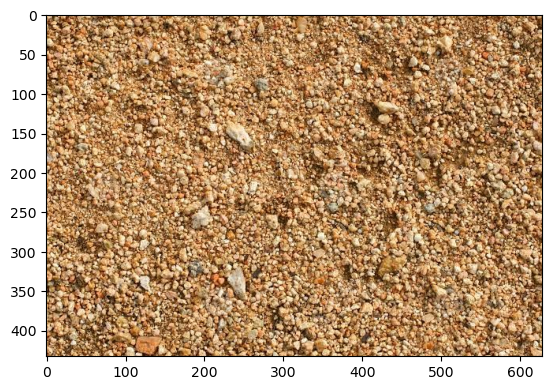

In [8]:
test_image_filepath = test_data_directory + r'/Sand/2.jpg'
print(make_prediction(test_image_filepath))

# PERCENTAGE OF A SOIL TYPE IN A MIXED SAMPLE

In [9]:
def split_images(image_dir, save_dir):
    classification_list = ['Gravel', 'Sand', 'Silt']
    for classification in classification_list:
        folder = image_dir + '/' + classification + '/'
        save_folder = save_dir + '/' + classification + '/'
        files = [f for f in listdir(folder) if isfile(join(folder, f))]

        for file in files:
            if '.ini' in file:
                continue
            fp = folder + file
            img = cv2.imread(fp)
            h,w,c = img.shape
            im_dim = 64
            for r in range(0,img.shape[0],im_dim):
                for c in range(0,img.shape[1],im_dim):
                    cropped_img = img[r:r+im_dim, c:c+im_dim,:]
                    ch, cw, cc = cropped_img.shape
                    if ch == im_dim and cw == im_dim:
                        write_path = f"{save_folder + str(randrange(100000))}img{r}_{c}.jpg"
                        cv2.imwrite(write_path,cropped_img)
                    else:
                        pass

# DIVIDING ORIGINAL IMAGE INTO PORTIONS

In [10]:
try:
    parent = training_data_directory.replace('/kaggle/input/soil-dataset/train', '')
    dirs = ['train_divided', 'test_divided']
    class_ = ["Gravel", "Sand", "Silt"]
    for dir in dirs:
        os.mkdir(os.path.join(parent, dir))
        for classification in class_:
            os.mkdir(os.path.join(parent, dir, classification))

    split_images(image_dir=training_data_directory,
                save_dir=training_data_directory.replace('/kaggle/input/soil-dataset/train', 'train_divided'))
    
    split_images(image_dir=test_data_directory,
                save_dir=test_data_directory.replace('/kaggle/input/soil-dataset/test', 'test_divided'))
except FileExistsError:
    pass

In [11]:
model_fp = os.getcwd()+'/'+'soil.h5'
print(model_fp)
model = load_model(model_fp)

/Users/sourasishmondal/Documents/Sustainivo/phyCompo/soil.h5


In [12]:
def classify_images(image_fp, model):
    classes = ['Gravel', 'Sand', 'Silt']
    gravel_count = 0
    sand_count = 0
    silt_count = 0

    img = cv2.imread(image_fp)
    img = cv2.resize(img,(1024,1024))
    im_dim = 256

    for r in range(0, img.shape[0], im_dim):
        for c in range(0, img.shape[1], im_dim):
            cropped_img = img[r:r + im_dim, c:c + im_dim, :]
            h, w, c = cropped_img.shape
            if h == im_dim and w == im_dim:
                classification = model_classify(cropped_img, model)
                if classification == classes[0]:
                    gravel_count += 1
                elif classification == classes[1]:
                    sand_count += 1
                elif classification == classes[2]:
                    silt_count += 1
            else:
                continue
    total_count = gravel_count + sand_count + silt_count
    proportion_array = [gravel_count / total_count, sand_count / total_count, silt_count / total_count]
    return proportion_array

def model_classify(cropped_img, model):
    classes = ['Gravel', 'Sand', 'Silt']
    image_array = cropped_img / 840.
    img_batch = np.expand_dims(image_array, axis=0)
    prediction_array = model.predict(img_batch)[0]
    first_idx = np.argmax(prediction_array)
    first_class = classes[first_idx]
    return first_class

def classify_percentage(image_fp):
    start = time.time()
    out = classify_images(image_fp=image_fp, model=model)
    finish = str(round(time.time() - start, 5))
    
    im = cv2.imread(image_fp)
    plt.imshow(im[:,:,[2, 1, 0]])

    print(f'''---
Percent Gravel: {round(out[0] * 100, 2)}%)
Percent Sand: {round(out[1] * 100, 2)}%)
Percent Silt: {round(out[2] * 100, 2)}%)
Time to Classify: {finish} seconds
---''')


# PERCENTAGE OF EACH SOIL TYPE IN A SAMPLE

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
---
Percent Gravel: 100.0%)
Percent Sand: 0.0%)
Percent Silt: 0.0%)
Time to Classify: 0.91136 seconds
---


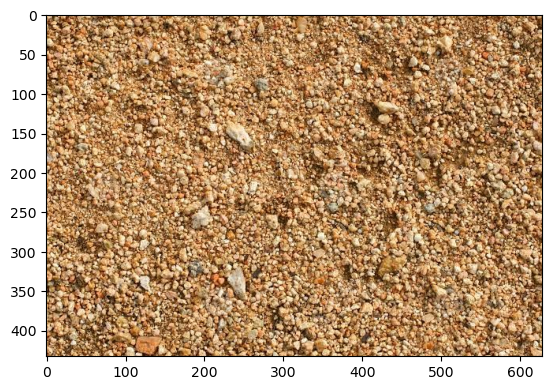

In [13]:
percentage_photo = test_data_directory + r"/Sand/2.jpg"
im = cv2.imread(percentage_photo) # load image
plt.imshow(im[:,:,[2,1,0]])
classify_percentage(image_fp=percentage_photo)

# PIPELINE


In [14]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder



In [15]:
steps = [("imputation constant",SimpleImputer(fill_value="not available",strategy ="constant")),
         ("onehot",OneHotEncoder(handle_unknown="ignore"))]

In [16]:
mypipe = Pipeline(steps)

In [17]:
from sklearn import set_config
set_config(display="diagram")



In [18]:
mypipe

Pipeline(steps=[('imputation constant',
                 SimpleImputer(fill_value='not available',
                               strategy='constant')),
                ('onehot', OneHotEncoder(handle_unknown='ignore'))])